# R-VGA in a logistic regression problem

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from sklearn.datasets import make_biclusters
from rebayes_mini.methods import recursive_vi_gauss as rvga

In [3]:
%config InlineBackend.figure_format = "retina"

In [57]:
n_samples = 500
X, y, cls = make_biclusters((n_samples, 2), 2, noise=1.0, minval=-3, maxval=3, random_state=314)
y = y.argmax(axis=0)

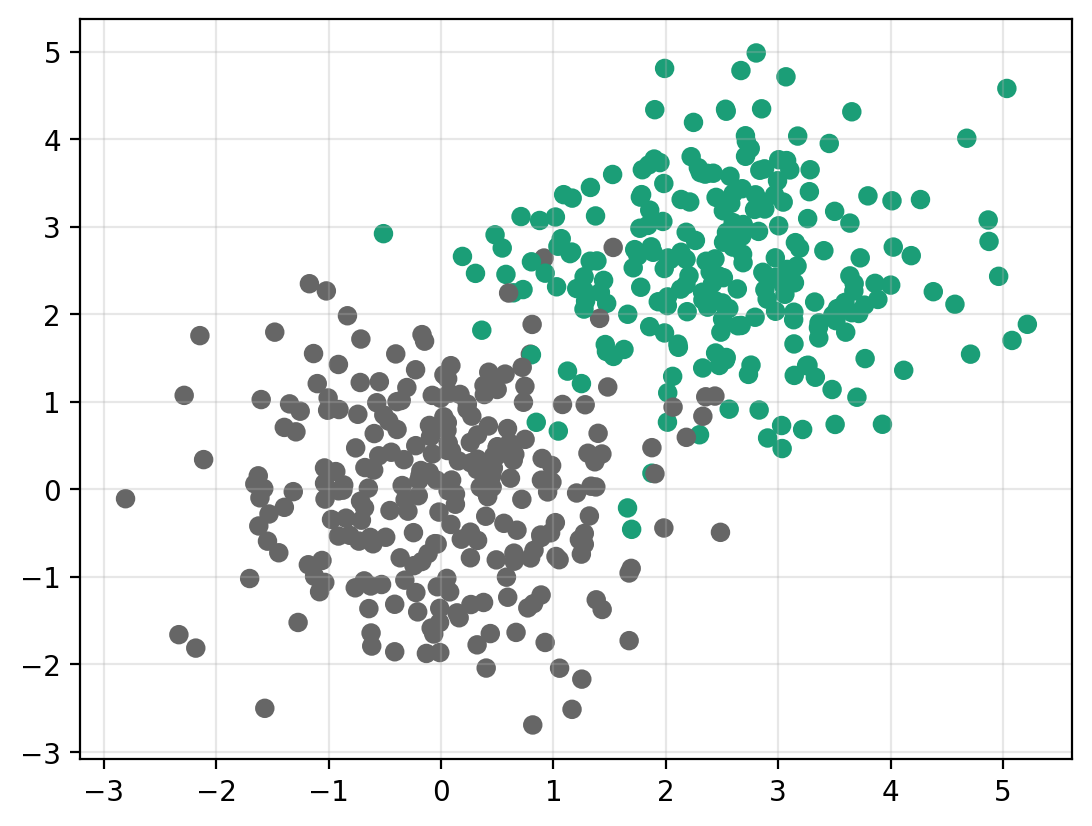

In [58]:
plt.scatter(*X.T, c=y, cmap="Dark2")
plt.grid(alpha=0.3)

In [81]:
def apply_fn(w, x):
    return jnp.atleast_1d(w @ x)

rvga_filter = rvga.BernoulliRVGA(apply_fn)

bel_init = rvga_filter.init_bel(jnp.zeros(3))

key = jax.random.PRNGKey(314)

Phi = jnp.c_[jnp.ones(n_samples), X]

In [82]:
_, mean_hist = rvga_filter.scan(key, bel_init, y[:, None], Phi)

In [83]:
preds = jnp.einsum("tm,tm->t", mean_hist, Phi)
preds = jax.nn.sigmoid(preds).round()
(preds == y).mean()

Array(0.95000005, dtype=float32)

In [84]:
(jax.nn.sigmoid(Phi @ mean_hist[-1]).round() == y)

Array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True, False,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True, False,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
       False,  True,  True,  True,  True,  True,  True, False,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True, False,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False,

In [85]:
jnp.ones((1, 20, 20)).shape

(1, 20, 20)

In [86]:
x = jnp.linspace(-3, 5, 20)
Z = jnp.mgrid[-3:5:20j,-3:5:20j]
S = jnp.concat([jnp.ones((1, 20, 20)), Z], axis=0)

S = jax.nn.sigmoid(jnp.einsum("dij,d->ij", S, mean_hist[-1]))

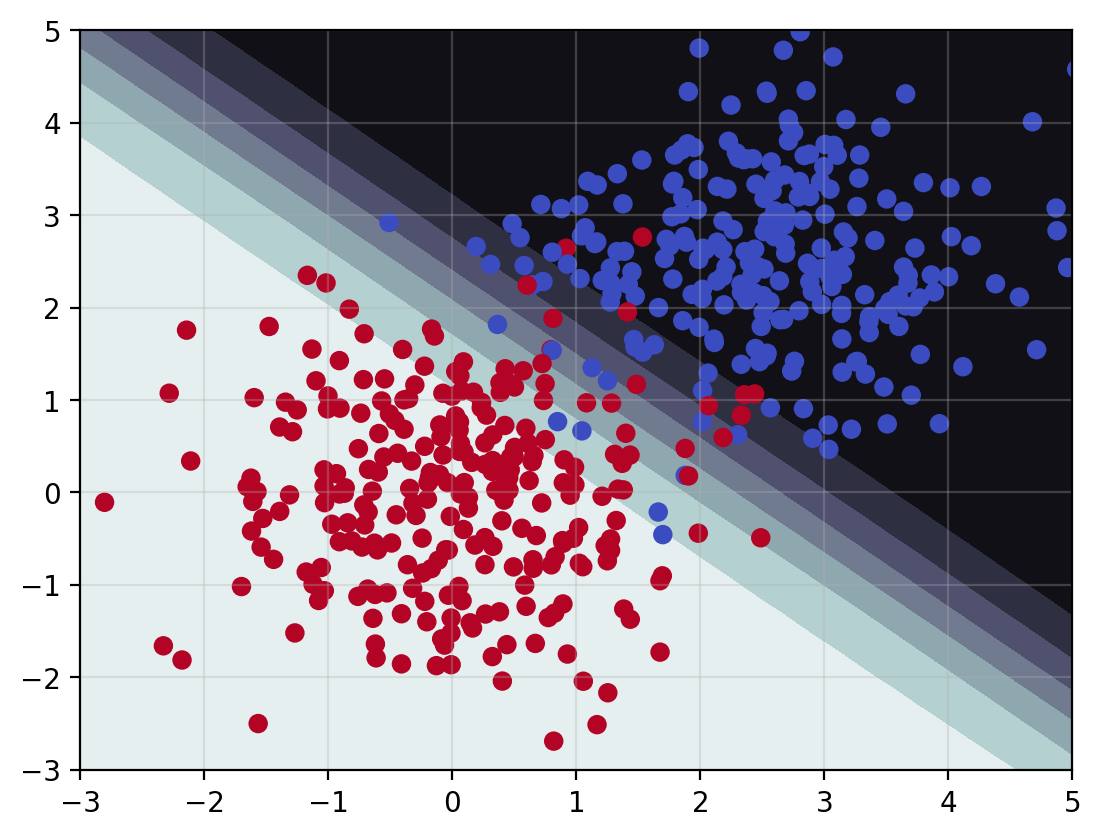

In [92]:
plt.contourf(x, x, S, cmap="bone")
plt.scatter(*X.T, c=y, cmap="coolwarm")
plt.xlim(-3, 5)
plt.ylim(-3, 5)
plt.grid(alpha=0.3)